# 0. Install and Import Dependencies

In [1]:
!pip list

Package                      Version
---------------------------- ---------------
absl-py                      2.3.1
asttokens                    3.0.0
astunparse                   1.6.3
beautifulsoup4               4.14.2
cachetools                   6.2.1
certifi                      2025.10.5
charset-normalizer           3.4.4
cmake                        4.1.2
colorama                     0.4.6
comm                         0.2.3
contourpy                    1.3.0
cycler                       0.12.1
debugpy                      1.8.16
decorator                    5.2.1
dlib                         19.22.99
exceptiongroup               1.3.0
executing                    2.2.0
filelock                     3.19.1
flatbuffers                  25.9.23
fonttools                    4.60.1
gast                         0.4.0
gdown                        5.2.0
google-auth                  2.41.1
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                      

In [2]:
!pip install opencv-python numpy==1.26.4 matplotlib imageio gdown tensorflow-cpu==2.10 tensorflow-directml-plugin cmake dlib-19.22.99-cp39-cp39-win_amd64.whl

Processing c:\users\roman\desktop\lipnet-main\dlib-19.22.99-cp39-cp39-win_amd64.whl
dlib is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [ ]:

import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import dlib
import matplotlib.cm as cm # Import the colormaps module


In [4]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [ ]:
# Initialize dlib's face detector and shape predictor
# NOTE: You must have the 'shape_predictor_68_face_landmarks.dat' file downloaded
# The path below assumes it's in the current directory.
# You can download it from: http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
predictor_path = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

def load_video(path: str):
    cap = cv2.VideoCapture(path)
    frames_list = []
    
    MOUTH_POINTS = list(range(48, 68))
    mouth_coords = None
    
    # First pass: Find mouth position in any frame
    while cap.isOpened() and mouth_coords is None:
        ret, frame = cap.read()
        if not ret or frame is None:
            break
            
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray, 1)  # Use upsampling for accuracy in first frame
        
        if len(faces) > 0:
            face = faces[0]
            landmarks = predictor(gray, face)
            
            # Get mouth coordinates from this frame
            mouth_coords = np.array([[landmarks.part(i).x, landmarks.part(i).y] 
                                   for i in MOUTH_POINTS])
            
            # Calculate mouth bounding box
            margin = 15
            x_min = np.min(mouth_coords[:, 0]) - margin
            x_max = np.max(mouth_coords[:, 0]) + margin
            y_min = np.min(mouth_coords[:, 1]) - margin
            y_max = np.max(mouth_coords[:, 1]) + margin
            
            # Ensure coordinates within frame bounds
            h, w = gray.shape
            x_min = max(0, x_min)
            x_max = min(w, x_max)
            y_min = max(0, y_min)
            y_max = min(h, y_max)
            
            # Store the mouth region coordinates
            mouth_region = (x_min, y_min, x_max, y_max)
            break
    
    # Reset video to beginning
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    # Second pass: Apply the same mouth crop to all frames
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame is None:
            break
            
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        if mouth_coords is not None:
            # Use the detected mouth position
            x_min, y_min, x_max, y_max = mouth_region
        else:
            # Fallback: Use manual crop (center of frame)
            h, w = gray.shape
            x_min, x_max = w//2 - 50, w//2 + 50
            y_min, y_max = h//2 - 25, h//2 + 25
        
        # Ensure coordinates are valid
        x_min, y_min = max(0, x_min), max(0, y_min)
        x_max, y_max = min(w, x_max), min(h, y_max)
        
        # Crop and resize
        cropped_mouth = gray[y_min:y_max, x_min:x_max]
        cropped_mouth = cv2.resize(cropped_mouth, (120, 60))
        cropped_mouth = np.expand_dims(cropped_mouth, axis=-1)
        
        frames_list.append(cropped_mouth)
    
    cap.release()
    
    # Ensure we have exactly 75 frames
    if len(frames_list) == 0:
        return tf.zeros([75, 60, 120, 1], dtype=tf.float32)
    
    # Pad or truncate to 75 frames
    if len(frames_list) < 75:
        last_frame = frames_list[-1] if frames_list else np.zeros((50, 100, 1))
        while len(frames_list) < 75:
            frames_list.append(last_frame.copy())
    else:
        frames_list = frames_list[:75]
    
    # Normalize
    frames_tensor = tf.constant(frames_list, dtype=tf.float32)
    mean = tf.math.reduce_mean(frames_tensor)
    std = tf.math.reduce_std(frames_tensor)
    epsilon = 1e-6
    normalized_frames = (frames_tensor - mean) / (std + epsilon)
    
    return normalized_frames

'def load_video(path:str) -> List[float]: \n    cap = cv2.VideoCapture(path)\n    frames = []\n    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): \n        ret, frame = cap.read()\n        if frame is None:  # Handle None frames\n            continue\n        frame = tf.image.rgb_to_grayscale(frame)\n        frames.append(frame[155:235,110:270,:])\n    cap.release()\n    \n    if len(frames) == 0:  # Handle case where all frames are None\n        return tf.zeros([75, 80, 160, 1], dtype=tf.float32)\n    \n    mean = tf.math.reduce_mean(frames)\n    std = tf.math.reduce_std(tf.cast(frames, tf.float32))\n    return tf.cast((frames - mean), tf.float32) / std\n'

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)



The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [9]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [10]:
char_to_num(['r','o','m','a','n'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([18, 15, 13,  1, 14], dtype=int64)>

In [11]:
num_to_char([18,  15,  13, 1, 14])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'r', b'o', b'm', b'a', b'n'], dtype=object)>

In [ ]:
def load_alignments(path: str): 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens.append(line[2])
    
    text = ' '.join(tokens)
    chars = list(text)
    
    # Convert to numbers
    encoded = []
    for char in chars:
        num = char_to_num(char)
        if hasattr(num, 'numpy'):
            encoded.append(int(num.numpy()))
        else:
            encoded.append(num)
    
    encoded = tf.constant(encoded, dtype=tf.int64)
    
    # Pad to exactly 40
    current_length = len(encoded)
    if current_length < 40:
        padding = [0] * (40 - current_length)
        encoded = tf.constant(encoded.numpy().tolist() + padding, dtype=tf.int64)
    else:
        encoded = tf.constant(encoded.numpy().tolist()[:40], dtype=tf.int64)
    
    return encoded


In [ ]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','all',f'{file_name}.mpg')
    alignment_path = os.path.join('data','align',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments


In [14]:
test_path = '.\\data\\all\\bbac1s.mpg'

In [15]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbac1s'

In [16]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))
len(frames)



75

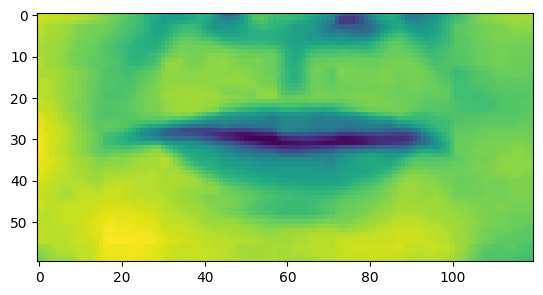

In [17]:
plt.imshow(frames[0])

In [18]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])


<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at c one soon'>

In [19]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [20]:
from matplotlib import pyplot as plt

In [ ]:
# ========== CONFIGURABLE VARIABLES ==========
BATCH_SIZE = 1
SHUFFLE_SIZE = 10000
TRAIN_SIZE = 30000
TEST_SIZE = 3000
PREFETCH_BUFFER = tf.data.AUTOTUNE

# Safe mapping with error handling
def safe_mappable_function(file_path):
    try:
        return mappable_function(file_path)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        # Return dummy data with correct shape
        return tf.zeros([75, 60, 120, 1], dtype=tf.float32), tf.zeros([40], dtype=tf.int32)

# Filter for bad data
def filter_malformed_data(video, label):
    # Check if video has correct rank (4) and valid dimensions
    has_correct_rank = tf.rank(video) == 4
    has_valid_dims = tf.reduce_all(tf.shape(video) > 0)
    # Also check label has correct rank (1)
    has_correct_label_rank = tf.rank(label) == 1
    return tf.logical_and(has_correct_rank, tf.logical_and(has_valid_dims, has_correct_label_rank))

# ========== OPTIMIZED DATASET PIPELINE ==========
data = tf.data.Dataset.list_files('./data/all/*.mpg')
data = data.shuffle(SHUFFLE_SIZE, reshuffle_each_iteration=True)
data = data.map(safe_mappable_function,tf.data.AUTOTUNE)  # PARALLEL PROCESSING
data = data.cache()  # Cache after mapping to avoid reprocessing
data = data.filter(filter_malformed_data)  # BAD DATA FILTER
data = data.padded_batch(BATCH_SIZE, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(PREFETCH_BUFFER)


# Train - Test split 
train = data.take(TRAIN_SIZE)
test = data.skip(TRAIN_SIZE).take(TEST_SIZE)

print(f"Dataset configured:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Shuffle size: {SHUFFLE_SIZE}")
print(f"  Train samples: {TRAIN_SIZE}")
print(f"  Test samples: {TEST_SIZE}")
print(f"  Prefetch buffer: {PREFETCH_BUFFER}")


Dataset configured:
  Batch size: 8
  Shuffle size: 1000
  Train samples: 300
  Test samples: 30
  Prefetch buffer: -1


In [22]:
frames, alignments = data.as_numpy_iterator().next()

In [23]:
len(frames)

8

In [24]:
sample = data.as_numpy_iterator()

In [25]:
val = sample.next(); val[0]

array([[[[[-0.76148254],
          [-0.7218975 ],
          [-0.64272743],
          ...,
          [-0.48438737],
          [-0.64272743],
          [-0.7218975 ]],

         [[-0.6823125 ],
          [-0.64272743],
          [-0.60314244],
          ...,
          [-0.60314244],
          [-0.76148254],
          [-0.8802376 ]],

         [[-0.64272743],
          [-0.60314244],
          [-0.60314244],
          ...,
          [-0.56355745],
          [-0.7218975 ],
          [-0.80106753]],

         ...,

         [[-0.48438737],
          [-0.44480234],
          [-0.3260473 ],
          ...,
          [-1.553183  ],
          [-1.751108  ],
          [-1.830278  ]],

         [[-0.24687725],
          [-0.5239724 ],
          [-0.7218975 ],
          ...,
          [-1.632353  ],
          [-1.671938  ],
          [-1.711523  ]],

         [[-0.08853717],
          [-0.44480234],
          [-0.80106753],
          ...,
          [-1.671938  ],
          [-1.632353  ],
          

In [ ]:
COLORMAP = cm.get_cmap('viridis')

frames_float = val[0][0] 

data_min = frames_float.min()
data_max = frames_float.max()

frames_normalized = (frames_float - data_min) / (data_max - data_min + 1e-6)
frames_normalized_2d = np.squeeze(frames_normalized, axis=-1)

frames_rgba = COLORMAP(frames_normalized_2d)

frames_rgb = frames_rgba[..., :3] 

frames_final = (frames_rgb * 255).astype(np.uint8)

imageio.mimsave('./animation.gif', frames_final, fps=10)
'''
imageio.mimsave('./animation.gif', val[0][1], fps=10)'''

C:\Users\Roman\AppData\Local\Temp\ipykernel_34792\1410724093.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  COLORMAP = cm.get_cmap('viridis')


"\nimageio.mimsave('./animation.gif', val[0][1], fps=10)"

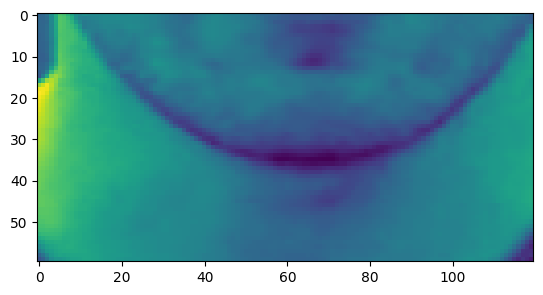

In [27]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [28]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue in q four now'>

# 3. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import MaxPool3D, Activation, TimeDistributed, Flatten, RNN, LSTMCell
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [30]:
data.as_numpy_iterator().next()[0][0].shape

(75, 60, 120, 1)

In [ ]:
model = Sequential()

model.add(Conv3D(128, 3, input_shape=(75,60,120,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

# Use RNN wrapper with LSTMCell instead of LSTM layer
# This gives GPU support without CuDNN dependency (we have an AMD RX 6800 XT)
model.add(Bidirectional(RNN(LSTMCell(128), return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(RNN(LSTMCell(128), return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

"import os\n\nmodel = Sequential()\nmodel.add(Conv3D(128, 3, input_shape=(75,50,100,1), padding='same'))\nmodel.add(Activation('relu'))\nmodel.add(MaxPool3D((1,2,2)))\n\nmodel.add(Conv3D(256, 3, padding='same'))\nmodel.add(Activation('relu'))\nmodel.add(MaxPool3D((1,2,2)))\n\nmodel.add(Conv3D(75, 3, padding='same'))\nmodel.add(Activation('relu'))\nmodel.add(MaxPool3D((1,2,2)))\n\nmodel.add(TimeDistributed(Flatten()))\n\n# Only change: Remove kernel_initializer='Orthogonal' from LSTM layers\nmodel.add(Bidirectional(LSTM(128, return_sequences=True)))\nmodel.add(Dropout(.5))\n\nmodel.add(Bidirectional(LSTM(128, return_sequences=True)))\nmodel.add(Dropout(.5))\n\nmodel.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))"

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 60, 120, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 60, 120, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 30, 60, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 30, 60, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 30, 60, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 15, 30, 256)  0         
 3D)                                                    

In [33]:
6*12*75

5400

In [34]:
yhat = model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [35]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'3333333oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo'>

In [36]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'3333333oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo'>

In [37]:
model.input_shape

(None, 75, 60, 120, 1)

In [38]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [39]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    # Get the lengths - keep as int64 for CTC
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    # Create tensors with correct shapes (keep the extra dimension)
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.original_dataset = dataset
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        # Only run every 5 epochs
        if (epoch + 1) % 5 != 0:
            return
            
        try:
            data = self.dataset.next()
        except StopIteration:
            self.dataset = self.original_dataset.as_numpy_iterator()
            data = self.dataset.next()
            
        yhat = self.model.predict(data[0][:1])
        
        # Dynamic sequence length based on batch size
        batch_size = yhat.shape[0]
        sequence_lengths = [75] * batch_size  # Match batch size
        
        decoded = tf.keras.backend.ctc_decode(yhat, sequence_lengths, greedy=False)[0][0].numpy()
        
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)
            

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss=CTCLoss,
    run_eagerly=False,  # Ensure graph execution
)

In [43]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True) 

In [44]:
schedule_callback = LearningRateScheduler(scheduler)

In [45]:
example_callback = ProduceExample(test)

In [ ]:
# Clear GPU memory first
tf.keras.backend.clear_session()

# Load the existing checkpoint
model.load_weights('models/checkpoint.weights.h5')

model.fit(
    train,
    validation_data=test,
    epochs=100,
    callbacks=[checkpoint_callback, schedule_callback, example_callback],
    verbose=1,
    workers=4,
    use_multiprocessing=True
)

"# Clear GPU memory first\nimport tensorflow as tf\ntf.keras.backend.clear_session()\n\n# Load the existing checkpoint\nmodel.load_weights('models/checkpoint.weights.h5')\n\nmodel.fit(\n    train,\n    validation_data=test,\n    epochs=100,\n    initial_epoch=91,  # Start from epoch 36 (0-indexed, so 29 means epoch 30)\n    callbacks=[checkpoint_callback, schedule_callback, example_callback],\n    verbose=1,\n    workers=4,\n    use_multiprocessing=True\n)"

# 5. Make a Prediction 

In [47]:
model.load_weights('models/checkpoint.weights.h5')

In [48]:
test_data = test.as_numpy_iterator()

In [49]:
#sample = test_data.next()

In [50]:
yhat = model.predict(sample[0])

TypeError: '_NumpyIterator' object is not subscriptable

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


TypeError: '_NumpyIterator' object is not subscriptable

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'l '>]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\lrwk8n.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay red with k eight now'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 0s 149ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay red with eight now'>]